# ORF recognition by CNN

In 105, we used Conv1D layers with filter width=3 with dropout to reduce overfitting. The simulated RNA lengths were 1000.

In 107, we showed CNN recognized frameshift with 4 Conv1D layers. Now try 2 layers.

In [1]:
import time 
t = time.time()
time.strftime('%Y-%m-%d %H:%M:%S %Z', time.localtime(t))

'2021-06-11 09:54:06 EDT'

In [2]:
PC_SEQUENCES=2000   # how many protein-coding sequences
NC_SEQUENCES=2000   # how many non-coding sequences
PC_TESTS=1000
NC_TESTS=1000
RNA_LEN=21            # how long is each sequence
CDS_LEN=15
ALPHABET=4          # how many different letters are possible
INPUT_SHAPE_2D = (RNA_LEN,ALPHABET,1) # Conv2D needs 3D inputs
INPUT_SHAPE = (RNA_LEN,ALPHABET) # Conv1D needs 2D inputs
FILTERS = 16   # how many different patterns the model looks for
NEURONS = 16
DROP_RATE = 0.2
WIDTH = 3   # how wide each pattern is, in bases
STRIDE_2D = (1,1)  # For Conv2D how far in each direction
STRIDE = 1 # For Conv1D, how far between pattern matches, in bases
EPOCHS=25  # how many times to train on all the data
SPLITS=5  # SPLITS=3 means train on 2/3 and validate on 1/3 
FOLDS=5  # train the model this many times (range 1 to SPLITS)

In [3]:
import sys
try:
    from google.colab import drive
    IN_COLAB = True
    print("On Google CoLab, mount cloud-local file, get our code from GitHub.")
    PATH='/content/drive/'
    #drive.mount(PATH,force_remount=True)  # hardly ever need this
    #drive.mount(PATH)    # Google will require login credentials
    DATAPATH=PATH+'My Drive/data/'  # must end in "/"
    import requests
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/RNA_gen.py')
    with open('RNA_gen.py', 'w') as f:
        f.write(r.text)  
    from RNA_gen import *
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/RNA_describe.py')
    with open('RNA_describe.py', 'w') as f:
        f.write(r.text)  
    from RNA_describe import ORF_counter
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/RNA_prep.py')
    with open('RNA_prep.py', 'w') as f:
        f.write(r.text)  
    from RNA_prep import *
except:
    print("CoLab not working. On my PC, use relative paths.")
    IN_COLAB = False
    DATAPATH='data/'  # must end in "/"
    sys.path.append("..") # append parent dir in order to use sibling dirs
    from SimTools.RNA_gen import *
    from SimTools.RNA_describe import ORF_counter
    from SimTools.RNA_prep import *

MODELPATH="BestModel"  # saved on cloud instance and lost after logout
#MODELPATH=DATAPATH+MODELPATH  # saved on Google Drive but requires login

if not assert_imported_RNA_gen():
    print("ERROR: Cannot use RNA_gen.")
if not assert_imported_RNA_prep():
    print("ERROR: Cannot use RNA_prep.")

CoLab not working. On my PC, use relative paths.


In [4]:
from os import listdir
import csv
from zipfile import ZipFile

import numpy as np
import pandas as pd
from scipy import stats  # mode

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from keras.models import Sequential
from keras.layers import Dense,Embedding,Dropout
from keras.layers import Conv1D,Conv2D
from keras.layers import Flatten,MaxPooling1D,MaxPooling2D
from keras.losses import BinaryCrossentropy
# tf.keras.losses.BinaryCrossentropy

import matplotlib.pyplot as plt
from matplotlib import colors
mycmap = colors.ListedColormap(['red','blue'])  # list color for label 0 then 1
np.set_printoptions(precision=2)


In [5]:
# Use code from our SimTools library.
def make_generators(seq_len,cds_len):
    pcgen = Collection_Generator()  
    pcgen.get_len_oracle().set_mean(seq_len)
    tora = Transcript_Oracle()
    tora.set_cds_len_mean(cds_len)  
    pcgen.set_seq_oracle(tora)
    ncgen = Collection_Generator()  
    ncgen.get_len_oracle().set_mean(seq_len)
    return pcgen,ncgen

pc_sim,nc_sim = make_generators(RNA_LEN-1,CDS_LEN)  # subtract one since we insert one later
pc_all = pc_sim.get_sequences(PC_SEQUENCES+PC_TESTS)
nc_all = pc_sim.get_sequences(NC_SEQUENCES+NC_TESTS) # YES, pc_sim!
print("Use",len(pc_all),"PC seqs")
print("Use",len(nc_all),"NC seqs")

Use 3000 PC seqs
Use 3000 NC seqs


In [6]:
# Describe the sequences
def describe_sequences(list_of_seq):
    oc = ORF_counter()
    num_seq = len(list_of_seq)
    rna_lens = np.zeros(num_seq)
    cds_lens = np.zeros(num_seq)
    for i in range(0,num_seq):
        rna_len = len(list_of_seq[i])
        rna_lens[i] = rna_len
        oc.set_sequence(list_of_seq[i])
        cds_lens[i] = oc.get_max_cds_len()
    print ("Average RNA length:",rna_lens.mean())
    print ("Average CDS length:",cds_lens.mean())
    
print("Simulated sequences prior to adjustment:")
print("PC seqs")
describe_sequences(pc_all)
print("NC seqs")
describe_sequences(nc_all)

Simulated sequences prior to adjustment:
PC seqs
Average RNA length: 20.0
Average CDS length: 13.896
NC seqs
Average RNA length: 20.0
Average CDS length: 13.942


In [7]:
import random
def alter_sequences(list_of_seq,center): 
    global next_pos,bases
    new_list = []
    for S in list_of_seq:
        seq_len = len(S)
        next_left = True
        next_base = random.choice(['A','C','G','T'])
        new_seq=""
        if center:
            half=seq_len//2
            new_seq=S[0:half]+next_base+S[half:]
        else:
            if next_left:
                new_seq=next_base+S
            else:
                new_seq=S+next_base 
            next_left = not next_left
        new_list.append(new_seq)
    return new_list
pc_all = alter_sequences(pc_all,False)
nc_all = alter_sequences(nc_all,True)

print("Simulated sequences after adjustment:")
print("PC train")
describe_sequences(pc_all)
print("NC train")
describe_sequences(nc_all)

Simulated sequences after adjustment:
PC train
Average RNA length: 21.0
Average CDS length: 13.919
NC train
Average RNA length: 21.0
Average CDS length: 3.815


In [8]:
pc_train=pc_all[:PC_SEQUENCES]
nc_train=nc_all[:NC_SEQUENCES]
pc_test=pc_all[PC_SEQUENCES:]
nc_test=nc_all[NC_SEQUENCES:]

In [9]:
# Use code from our SimTools library.
X,y = prepare_inputs_len_x_alphabet(pc_train,nc_train,ALPHABET) # shuffles
print("Data ready.")

Data ready.


In [10]:
def make_DNN():
    print("make_DNN")
    print("input shape:",INPUT_SHAPE)
    dnn = Sequential()
    #dnn.add(Embedding(input_dim=INPUT_SHAPE,output_dim=INPUT_SHAPE)) 
    dnn.add(Conv1D(filters=FILTERS,kernel_size=WIDTH,strides=STRIDE,padding="same",
            input_shape=INPUT_SHAPE))
    dnn.add(Conv1D(filters=FILTERS,kernel_size=WIDTH,strides=STRIDE,padding="same"))
    dnn.add(MaxPooling1D())
    #dnn.add(Conv1D(filters=FILTERS,kernel_size=WIDTH,strides=STRIDE,padding="same"))
    #dnn.add(Conv1D(filters=FILTERS,kernel_size=WIDTH,strides=STRIDE,padding="same"))
    #dnn.add(MaxPooling1D())
    dnn.add(Flatten())
    dnn.add(Dense(NEURONS,activation="sigmoid",dtype=np.float32))   
    dnn.add(Dropout(DROP_RATE))
    dnn.add(Dense(1,activation="sigmoid",dtype=np.float32))   
    dnn.compile(optimizer='adam',
                loss=BinaryCrossentropy(from_logits=False),
                metrics=['accuracy'])   # add to default metrics=loss
    dnn.build(input_shape=INPUT_SHAPE)
    #ln_rate = tf.keras.optimizers.Adam(learning_rate = LN_RATE)
    #bc=tf.keras.losses.BinaryCrossentropy(from_logits=False)
    #model.compile(loss=bc, optimizer=ln_rate, metrics=["accuracy"])
    return dnn
model = make_DNN()
print(model.summary())

make_DNN
input shape: (21, 4)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 21, 16)            208       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 21, 16)            784       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 10, 16)            0         
_________________________________________________________________
flatten (Flatten)            (None, 160)               0         
_________________________________________________________________
dense (Dense)                (None, 16)                2576      
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)           

In [11]:
from keras.callbacks import ModelCheckpoint
def do_cross_validation(X,y):
    cv_scores = []
    fold=0
    mycallbacks = [ModelCheckpoint(
        filepath=MODELPATH, save_best_only=True, 
        monitor='val_accuracy', mode='max')]   
    splitter = KFold(n_splits=SPLITS)  # this does not shuffle
    for train_index,valid_index in splitter.split(X):
        if fold < FOLDS:
            fold += 1
            X_train=X[train_index] # inputs for training
            y_train=y[train_index] # labels for training
            X_valid=X[valid_index] # inputs for validation
            y_valid=y[valid_index] # labels for validation
            print("MODEL")
            # Call constructor on each CV. Else, continually improves the same model.
            model = model = make_DNN()
            print("FIT")  # model.fit() implements learning
            start_time=time.time()
            history=model.fit(X_train, y_train, 
                    epochs=EPOCHS, 
                    verbose=1,  # ascii art while learning
                    callbacks=mycallbacks,   # called at end of each epoch
                    validation_data=(X_valid,y_valid))
            end_time=time.time()
            elapsed_time=(end_time-start_time)                        
            print("Fold %d, %d epochs, %d sec"%(fold,EPOCHS,elapsed_time))
            # print(history.history.keys())  # all these keys will be shown in figure
            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1) # any losses > 1 will be off the scale
            plt.show()


MODEL
make_DNN
input shape: (21, 4)
FIT
Epoch 1/25
100/100 [==============================] - 2s 15ms/step - loss: 0.6888 - accuracy: 0.5427 - val_loss: 0.5474 - val_accuracy: 0.8138
INFO:tensorflow:Assets written to: BestModel/assets
Epoch 2/25
100/100 [==============================] - 0s 5ms/step - loss: 0.4811 - accuracy: 0.8226 - val_loss: 0.3566 - val_accuracy: 0.8637
INFO:tensorflow:Assets written to: BestModel/assets
Epoch 3/25
100/100 [==============================] - 1s 5ms/step - loss: 0.3166 - accuracy: 0.8885 - val_loss: 0.2776 - val_accuracy: 0.8925
INFO:tensorflow:Assets written to: BestModel/assets
Epoch 4/25
100/100 [==============================] - 0s 5ms/step - loss: 0.2345 - accuracy: 0.9232 - val_loss: 0.2178 - val_accuracy: 0.9237
INFO:tensorflow:Assets written to: BestModel/assets
Epoch 5/25
100/100 [==============================] - 0s 5ms/step - loss: 0.1821 - accuracy: 0.9428 - val_loss: 0.1922 - val_accuracy: 0.9350
INFO:tensorflow:Assets written to: BestMo

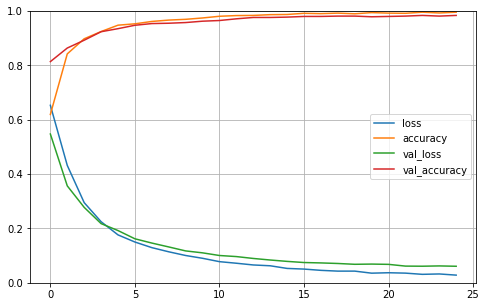

MODEL
make_DNN
input shape: (21, 4)
FIT
Epoch 1/25
100/100 [==============================] - 1s 6ms/step - loss: 0.6891 - accuracy: 0.5575 - val_loss: 0.5636 - val_accuracy: 0.8075
Epoch 2/25
100/100 [==============================] - 0s 4ms/step - loss: 0.5138 - accuracy: 0.7876 - val_loss: 0.3430 - val_accuracy: 0.8838
Epoch 3/25
100/100 [==============================] - 0s 4ms/step - loss: 0.3308 - accuracy: 0.8900 - val_loss: 0.2547 - val_accuracy: 0.9262
Epoch 4/25
100/100 [==============================] - 0s 4ms/step - loss: 0.2671 - accuracy: 0.9143 - val_loss: 0.1820 - val_accuracy: 0.9575
Epoch 5/25
100/100 [==============================] - 0s 5ms/step - loss: 0.2060 - accuracy: 0.9394 - val_loss: 0.1391 - val_accuracy: 0.9650
Epoch 6/25
100/100 [==============================] - 0s 4ms/step - loss: 0.1674 - accuracy: 0.9471 - val_loss: 0.1096 - val_accuracy: 0.9825
Epoch 7/25
100/100 [==============================] - 0s 4ms/step - loss: 0.1243 - accuracy: 0.9692 - val_lo

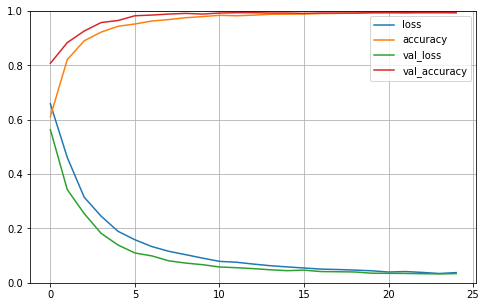

MODEL
make_DNN
input shape: (21, 4)
FIT
Epoch 1/25
100/100 [==============================] - 1s 6ms/step - loss: 0.6800 - accuracy: 0.5704 - val_loss: 0.5676 - val_accuracy: 0.8050
Epoch 2/25
100/100 [==============================] - 0s 5ms/step - loss: 0.5088 - accuracy: 0.8028 - val_loss: 0.3646 - val_accuracy: 0.8587
Epoch 3/25
100/100 [==============================] - 0s 5ms/step - loss: 0.3522 - accuracy: 0.8707 - val_loss: 0.2924 - val_accuracy: 0.8900
Epoch 4/25
100/100 [==============================] - 0s 4ms/step - loss: 0.2794 - accuracy: 0.9043 - val_loss: 0.2471 - val_accuracy: 0.9050
Epoch 5/25
100/100 [==============================] - 0s 4ms/step - loss: 0.2308 - accuracy: 0.9222 - val_loss: 0.2075 - val_accuracy: 0.9237
Epoch 6/25
100/100 [==============================] - 0s 4ms/step - loss: 0.2091 - accuracy: 0.9212 - val_loss: 0.1781 - val_accuracy: 0.9463
Epoch 7/25
100/100 [==============================] - 0s 4ms/step - loss: 0.1717 - accuracy: 0.9416 - val_lo

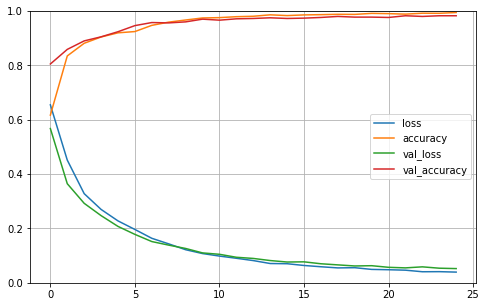

MODEL
make_DNN
input shape: (21, 4)
FIT
Epoch 1/25
100/100 [==============================] - 1s 6ms/step - loss: 0.7206 - accuracy: 0.5202 - val_loss: 0.6276 - val_accuracy: 0.7837
Epoch 2/25
100/100 [==============================] - 0s 5ms/step - loss: 0.5826 - accuracy: 0.7562 - val_loss: 0.4172 - val_accuracy: 0.8625
Epoch 3/25
100/100 [==============================] - 0s 5ms/step - loss: 0.3847 - accuracy: 0.8681 - val_loss: 0.3136 - val_accuracy: 0.8863
Epoch 4/25
100/100 [==============================] - 0s 5ms/step - loss: 0.2928 - accuracy: 0.8984 - val_loss: 0.2570 - val_accuracy: 0.9062
Epoch 5/25
100/100 [==============================] - 0s 5ms/step - loss: 0.2337 - accuracy: 0.9194 - val_loss: 0.2196 - val_accuracy: 0.9237
Epoch 6/25
100/100 [==============================] - 1s 6ms/step - loss: 0.1948 - accuracy: 0.9360 - val_loss: 0.1886 - val_accuracy: 0.9287
Epoch 7/25
100/100 [==============================] - 1s 6ms/step - loss: 0.1695 - accuracy: 0.9480 - val_lo

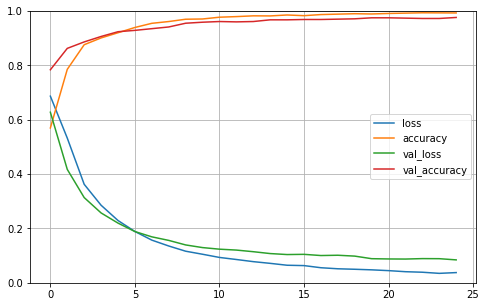

MODEL
make_DNN
input shape: (21, 4)
FIT
Epoch 1/25
100/100 [==============================] - 1s 8ms/step - loss: 0.7125 - accuracy: 0.5518 - val_loss: 0.5645 - val_accuracy: 0.8225
Epoch 2/25
100/100 [==============================] - 0s 5ms/step - loss: 0.5116 - accuracy: 0.8179 - val_loss: 0.3500 - val_accuracy: 0.8913
Epoch 3/25
100/100 [==============================] - 0s 5ms/step - loss: 0.3311 - accuracy: 0.8867 - val_loss: 0.2577 - val_accuracy: 0.9125
Epoch 4/25
100/100 [==============================] - 0s 4ms/step - loss: 0.2637 - accuracy: 0.9137 - val_loss: 0.2018 - val_accuracy: 0.9450
Epoch 5/25
100/100 [==============================] - 0s 4ms/step - loss: 0.2158 - accuracy: 0.9268 - val_loss: 0.1618 - val_accuracy: 0.9575
Epoch 6/25
100/100 [==============================] - 1s 5ms/step - loss: 0.1770 - accuracy: 0.9484 - val_loss: 0.1360 - val_accuracy: 0.9588
Epoch 7/25
100/100 [==============================] - 0s 4ms/step - loss: 0.1489 - accuracy: 0.9612 - val_lo

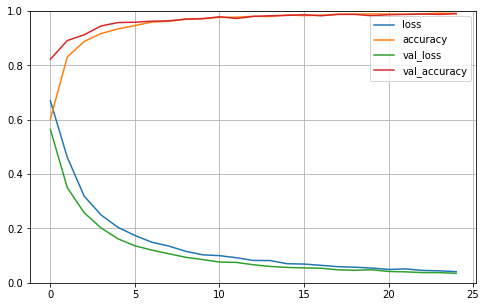

In [12]:
do_cross_validation(X,y)

In [13]:
from keras.models import load_model
X,y = prepare_inputs_len_x_alphabet(pc_test,nc_test,ALPHABET)
best_model=load_model(MODELPATH)
scores = best_model.evaluate(X, y, verbose=0)
print("The best model parameters were saved during cross-validation.")
print("Best was defined as maximum validation accuracy at end of any epoch.")
print("Now re-load the best model and test it on previously unseen data.")
print("Test on",len(pc_test),"PC seqs")
print("Test on",len(nc_test),"NC seqs")
print("%s: %.2f%%" % (best_model.metrics_names[1], scores[1]*100))


The best model parameters were saved during cross-validation.
Best was defined as maximum validation accuracy at end of any epoch.
Now re-load the best model and test it on previously unseen data.
Test on 1000 PC seqs
Test on 1000 NC seqs
accuracy: 98.75%


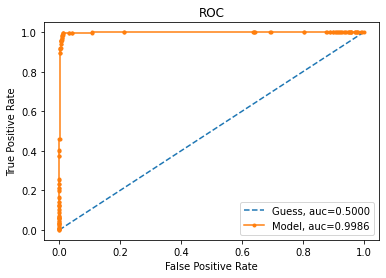

AUC: 99.86%


In [14]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
ns_probs = [0 for _ in range(len(y))]
bm_probs = best_model.predict(X)
ns_auc = roc_auc_score(y, ns_probs)
bm_auc = roc_auc_score(y, bm_probs)
ns_fpr, ns_tpr, _ = roc_curve(y, ns_probs)
bm_fpr, bm_tpr, _ = roc_curve(y, bm_probs)
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Guess, auc=%.4f'%ns_auc)
plt.plot(bm_fpr, bm_tpr, marker='.', label='Model, auc=%.4f'%bm_auc)
plt.title('ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()
print("%s: %.2f%%" %('AUC',bm_auc*100.0))


In [15]:
t = time.time()
time.strftime('%Y-%m-%d %H:%M:%S %Z', time.localtime(t))

'2021-06-11 09:55:53 EDT'

## Conclusion
The CNN is very capable of learning ORF/nonORF where the only difference is a frameshift indel to an ORF in order to create the nonORF.